In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('..\spreadsheet_data\i16WB_filtered.csv')
# Filter out slabs that were replaced during time period
df = df[df['Replaced'].notnull() == False]
df = df[df['Replaced and Broken'].notnull() == False]
df = df[df['2014'] != 'R']

df = df.drop(columns=['Replaced', 'Replaced and Broken', 'Interstate', 'Direction', 'Year Replaced', 'Possibly OR'])
df.head()

,MP From,MP To,2014 Slab ID,BY Length (ft),2014,2015,2016,2017,2018
0,22.000000,21.997566,3,12.85,NC,NC,NC,NC,NC
1,21.997566,21.994286,4,17.32,NC,NC,NC,NC,NC
2,21.994286,21.991244,5,16.06,NC,NC,NC,NC,NC
3,21.991244,21.987169,6,21.52,NC,NC,NC,NC,NC
4,21.987169,21.982809,7,23.02,NC,NC,NC,NC,NC


In [20]:
#Grouping data by mile marker (every mile). Data will be put into bins with (m, m + 1] where m is an integer and a mile marker.
 
def group_by_mile(df, start, end):
    df_by_mile = {}
    for i in range(end, start, -1):
        mile_df = df[(df['MP From'] <= i) & (df['MP From'] > i - 1)]
        df_by_mile[i] = mile_df
        
        
    return df_by_mile

def create_TPM_by_mile(df_by_mile, mile_start, mile_end, year_start, year_end):
    TPMs = {}
    for mile in range(mile_end, mile_start, -1):
        for year in range(year_start + 1, year_end + 1):
            # Creates a df with the number of slabs that transition from each of the one states to another
            TPM = df_by_mile[mile].groupby([str(year - 1), str(year)]).size().unstack()
            # Reindex so that the rows and columns so that the upper triangluar shape can take form
            TPM = TPM.reindex(['NC', 'L1', 'T1', 'L2', 'T2', 'CC', 'SS'])
            TPM = TPM.reindex(['NC', 'L1', 'T1', 'L2', 'T2', 'CC', 'SS'], axis=1)
            TPM = TPM.fillna(0)
            # Calculate percentages
            TPM = TPM.div(TPM.sum(axis=1), axis=0).round(3)
            TPM = TPM.fillna(0)
            # a TPM can be accessed by the milemarker and the year, where the transition happens from year-1 to year.   
            TPMs[(mile, year)] = TPM
    return TPMs


df_by_mile = group_by_mile(df, 12, 22)
df_by_mile_aggregate = {}
TPMs = create_TPM_by_mile(df_by_mile, 12, 22, 2014, 2018)


,MP From,MP To,2014 Slab ID,BY Length (ft),2014,2015,2016,2017,2018
289,20.997452,20.993009,292,23.46,NC,NC,NC,NC,NC
290,20.993009,20.989710,293,17.42,NC,NC,NC,NC,NC
291,20.989710,20.986752,294,15.62,NC,NC,NC,NC,NC
292,20.986752,20.982587,295,21.99,L1,CC,SS,SS,SS
293,20.982587,20.978163,296,23.36,NC,T2,T2,T2,T2


2018,NC,L1,T1,L2,T2,CC,SS
2017,,,,,,,
NC,0.978,0.000,0.011,0.000,0.011,0.0,0.0
L1,0.000,0.571,0.000,0.143,0.286,0.0,0.0
T1,0.000,0.000,0.167,0.000,0.833,0.0,0.0
L2,0.000,0.000,0.000,1.000,0.000,0.0,0.0
T2,0.000,0.000,0.000,0.000,0.900,0.0,0.1
CC,0.000,0.000,0.000,0.000,0.000,0.0,0.0
SS,0.000,0.000,0.000,0.000,0.000,0.0,1.0


# What is the percentage of NCs that transition to another state?

         22     21     20     19     18     17     16     15     14     13
2015  0.039  0.036  0.024  0.046  0.070  0.053  0.055  0.028  0.033  0.039
2016  0.026  0.038  0.012  0.049  0.074  0.086  0.041  0.012  0.009  0.040
2017  0.037  0.035  0.017  0.041  0.103  0.067  0.048  0.030  0.025  0.051
2018  0.024  0.027  0.013  0.036  0.075  0.007  0.018  0.009  0.035  0.022


<AxesSubplot:title={'center':'Percentage of NC slabs that transition to damaged states over time'}, xlabel='Time', ylabel='Percent Change from NC to Damaged'>

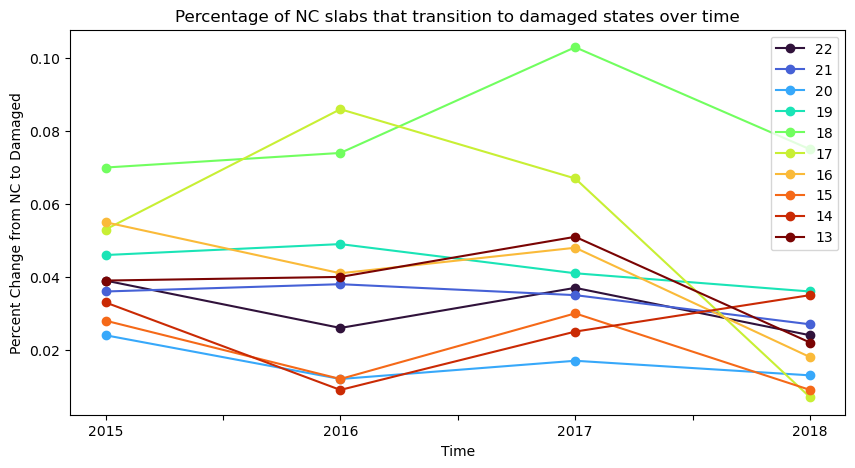

In [50]:
def calc_NC_to_damaged(mile, year):
    return TPMs[(mile, year)].loc['NC', 'L1'] + TPMs[(mile, year)].loc['NC', 'T1'] + TPMs[(mile, year)].loc['NC', 'L2'] + TPMs[(mile, year)].loc['NC', 'T2'] + TPMs[(mile, year)].loc['NC', 'CC'] + TPMs[(mile, year)].loc['NC', 'SS']

table = {}

for mile in range(22, 12, -1):
    table[mile] = []
    for year in range(2015, 2019):
        table[mile].append(calc_NC_to_damaged(mile, year))




NC_to_damaged = pd.DataFrame(table)
NC_to_damaged.index = ['2015', '2016', '2017', '2018']

print(NC_to_damaged)
NC_to_damaged.plot(use_index=True, marker='o', title='Percentage of NC slabs that transition to damaged states over time', colormap='turbo', figsize=(10, 5), ylabel='Percent Change from NC to Damaged', xlabel='Time')



## Another Question: Is the percentage change from NC to Damaged related to the percentage of slabs damaged?

,Percent Damaged,Percent Change of NC to Damaged
0,0.218,0.039
1,0.239,0.026
2,0.266,0.037
3,0.284,0.024
4,0.219,0.036
5,0.248,0.038
6,0.275,0.035
7,0.295,0.027
8,0.114,0.024
9,0.125,0.012


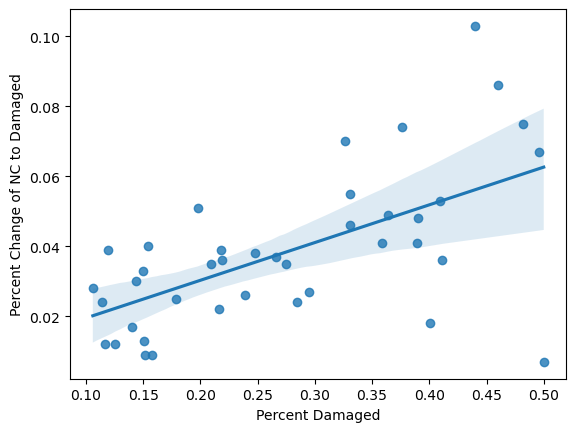

In [63]:
def pair_values():
    rate_of_damage_vs_damage = {'Percent Damaged' : [], 'Percentage of NC that Transitioned to Damaged' : []}
    for mile in range(22, 12, -1):
        for year in range(2015, 2019): 
            freq = pd.crosstab(df_by_mile[mile][str(year)], 'count')
            freq['relative freq'] = freq['count'] / freq['count'].sum()
            percent_damaged = (1 - freq.loc['NC', 'relative freq']).round(3)
            rate_of_damage = NC_to_damaged.loc[str(year), mile]
            rate_of_damage_vs_damage['Percent Damaged'].append(percent_damaged)
            rate_of_damage_vs_damage['Percentage of NC that Transitioned to Damaged'].append(rate_of_damage)
    return pd.DataFrame(rate_of_damage_vs_damage)

rate_of_damage_vs_damage = pair_values()
display(rate_of_damage_vs_damage)

sns.regplot(x='Percent Damaged', y='Percent Change of NC to Damaged', data=rate_of_damage_vs_damage, scatter=True)

rate_of_damage_vs_damage.to_csv('..\spreadsheet_data\\rate_of_damage_vs_damage.csv')
